# Extracting Financial Data From SEC Filings 
## Contents
### 1. Download Filing URLs
### 2. Parse Filings
#### 2.1 Income Statements
#### 2.2 Balance Sheets
#### 2.3 Cashflow Statements 
##### Note: This notebook is currently configured to focus on annual data. To change this feature, set `self.only_annual_data = False` in the constructor for the `Extraction` class.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sec_api import XbrlApi, QueryApi

# 1. Download Filing URLs

In [2]:
class FilingSearch:
    def __init__(self, API_KEY):
        self.API_KEY = API_KEY
        self.queryApi = QueryApi(api_key=API_KEY)

    def search(self, ticker, init_year, final_year, filing_type):
        """
        On each search request, the PLACEHOLDER in the base_query is replaced
        with our form type filter and with a date range filter.
        """
        base_query = {
            "query": {
                "query_string": {
                    "query": "PLACEHOLDER",  # this will be set during runtime
                    "time_zone": "America/New_York",
                }
            },
            "from": "0",
            "size": "200",  # dont change this
            # sort returned filings by the filedAt key/value
            "sort": [{"filedAt": {"order": "desc"}}],
        }

        # open the file we use to store the filing URLs
        out_file = ticker + "_" + filing_type + "_urls.csv"
        new_file = not (os.path.isfile(out_file))
        log_file = open(out_file, "a")
        if new_file:
            log_file.write("year,url\n")

        # start with filings filed in 2022, then 2020, 2019, ... up to 2010
        # uncomment next line to fetch all filings filed from 2022-2010
        # for year in range(2022, 2009, -1):
        for year in range(final_year, init_year - 1, -1):
            print("Starting download for year {year}".format(year=year))

            # a single search universe is represented as a month of the given year
            for month in range(1, 13, 1):
                # get 10-Q and 10-Q/A filings filed in year and month
                # resulting query example: "formType:\"10-Q\" AND filedAt:[2021-01-01 TO 2021-01-31]"
                universe_query = (
                    "ticker:"
                    + ticker
                    + " AND "
                    + 'formType:"'
                    + filing_type
                    + '" AND '
                    + "filedAt:[{year}-{month:02d}-01 TO {year}-{month:02d}-31]".format(
                        year=year, month=month
                    )
                )

                # set new query universe for year-month combination
                base_query["query"]["query_string"]["query"] = universe_query

                # paginate through results by increasing "from" parameter
                # until we don't find any matches anymore
                # uncomment next line to fetch all 10,000 filings
                # for from_batch in range(0, 9800, 200):
                for from_batch in range(0, 400, 200):
                    # set new "from" starting position of search
                    base_query["from"] = from_batch

                    response = self.queryApi.get_filings(base_query)

                    # no more filings in search universe
                    if len(response["filings"]) == 0:
                        break

                    # for each filing, only save the URL pointing to the filing itself
                    # and ignore all other data.
                    # the URL is set in the dict key "linkToFilingDetails"
                    urls_list = list(
                        map(lambda x: x["linkToFilingDetails"], response["filings"])
                    )
                    urls_list = [str(year) + "," + url for url in urls_list]

                    # transform list of URLs into one string by joining all list elements
                    # and add a new-line character between each element.
                    urls_string = "\n".join(urls_list) + "\n"

                    log_file.write(urls_string)

                # print("Filing URLs downloaded for {year}-{month:02d}".format(year=year, month=month))

        log_file.close()

        print("All URLs downloaded to", out_file)

In [3]:
API_KEY = "5c34e2747280f96d85701b33c98264bbd9b4e55e2474b88d84376896849e1c36"

In [4]:
ticker = "AAPL"
init_year = 2014
final_year = 2023
form = "10-K"

In [5]:
search = FilingSearch(API_KEY)

In [6]:
search.search(ticker, init_year, final_year, form)

Starting download for year 2023
Starting download for year 2022
Starting download for year 2021
Starting download for year 2020
Starting download for year 2019
Starting download for year 2018
Starting download for year 2017
Starting download for year 2016
Starting download for year 2015
Starting download for year 2014
All URLs downloaded to AAPL_10-K_urls.csv


# 2. Parse Filings

In [7]:
class Extraction:
    def __init__(self, API_KEY):
        self.API_KEY = API_KEY
        self.xbrlApi = XbrlApi(API_KEY)
        self.only_annual_data = True
        self.xblr_list = None
        self.URLs = None
        self.income_statements = None
        self.balance_sheets = None
        self.cashflow_statements = None

    def get_urls(self, url_file):
        self.URLs = list(pd.read_csv(url_file)["url"])

    def get_xbrls(self):
        self.xbrl_list = list(map(self.xbrlApi.xbrl_to_json, self.URLs))

    def get_income_statement(self, xbrl_json):
        # convert BBRL-JSON of income statement to pandas dataframe
        income_statement_store = {}

        # iterate over each US GAAP item in the income statement
        for usGaapItem in xbrl_json["StatementsOfIncome"]:
            values = []
            indices = []

            for fact in xbrl_json["StatementsOfIncome"][usGaapItem]:
                # only consider items without segment. not required for this analysis
                if "segment" not in fact:
                    index = (
                        fact["period"]["startDate"] + "-" + fact["period"]["endDate"]
                    )
                    # ensure no index duplicates are created
                    if index not in indices:
                        values.append(fact["value"])
                        indices.append(index)

            income_statement_store[usGaapItem] = pd.Series(values, index=indices)

        income_statement = pd.DataFrame(income_statement_store)
        # switch columns and rows so that US GAAP items are rows and column headers represent date ranges
        return income_statement.T

    def merge_income_statements(self):
        income_list = list(map(self.get_income_statement, self.xbrl_list))
        income_statements_merged = (
            pd.concat(income_list, axis=0, sort=False).sort_index().reset_index()
        )
        # convert cells to float
        income_statements_merged = income_statements_merged.applymap(
            lambda x: pd.to_numeric(x, errors="ignore")
        )
        income_statements = (
            income_statements_merged.groupby("index")
            .max()
            .reindex(income_list[0].index)
        )
        # loop over the columns
        if self.only_annual_data:
            for col in income_statements.columns[1:]:
                # extract start and end dates from the column label
                splitted = col.split("-")
                start = "-".join(splitted[:3])
                end = "-".join(splitted[3:])

                # convert start and end dates to datetime objects
                start_date = pd.to_datetime(start)
                end_date = pd.to_datetime(end)

                # calculate the duration between start and end dates
                duration = (end_date - start_date).days / 360

                # drop the column if duration is less than a year
                if duration < 1:
                    income_statements.drop(columns=[col], inplace=True)

        cols = sorted(list(income_statements.columns))
        income_statements = income_statements[cols]
        self.income_statements = income_statements

    def get_balance_sheets(self, xbrl_json):
        balance_sheet_store = {}

        # iterate over each US GAAP item in the balance sheet
        for usGaapItem in xbrl_json["BalanceSheets"]:
            values = []
            indices = []

            for fact in xbrl_json["BalanceSheets"][usGaapItem]:
                # only consider items without segment. not required for this analysis
                if "segment" not in fact.keys():
                    # print(fact)
                    index = fact["period"]["instant"]
                    # ensure no index duplicates are created
                    if index not in indices:
                        if "value" in fact:
                            values.append(fact["value"])
                        else:
                            values.append(np.nan)
                        indices.append(index)

            balance_sheet_store[usGaapItem] = pd.Series(values, index=indices)

        balance_sheet = pd.DataFrame(balance_sheet_store)
        # switch columns and rows so that US GAAP items are rows and column headers represent date ranges
        return balance_sheet.T

    def merge_balance_sheets(self):
        balance_sheet_list = list(map(self.get_balance_sheets, self.xbrl_list))
        balance_sheets_merged = (
            pd.concat(balance_sheet_list, axis=0, sort=False).sort_index().reset_index()
        )
        # convert cells to float
        balance_sheets_merged = balance_sheets_merged.applymap(
            lambda x: pd.to_numeric(x, errors="ignore")
        )
        balance_sheets = (
            balance_sheets_merged.groupby("index")
            .max()
            .reindex(balance_sheet_list[0].index)
        )
        cols = sorted(list(balance_sheets.columns))
        balance_sheets = balance_sheets[cols]
        self.balance_sheets = balance_sheets

    def get_cashflow(self, xbrl_json):
        cashflow_statement_store = {}

        # iterate over each US GAAP item in the cashflow statement
        for usGaapItem in xbrl_json["StatementsOfCashFlows"]:
            values = []
            indices = []

            for fact in xbrl_json["StatementsOfCashFlows"][usGaapItem]:
                # only consider items without segment. not required for this analysis
                if "segment" not in fact.keys():
                    # print(fact)
                    if "instant" in fact["period"]:
                        index = fact["period"]["instant"]
                    else:
                        index = (
                            fact["period"]["startDate"]
                            + "-"
                            + fact["period"]["endDate"]
                        )
                    # ensure no index duplicates are created
                    if index not in indices:
                        if "value" in fact:
                            values.append(fact["value"])
                        else:
                            values.append(np.nan)
                        indices.append(index)

            cashflow_statement_store[usGaapItem] = pd.Series(values, index=indices)

        cashflow_statement = pd.DataFrame(cashflow_statement_store)
        # switch columns and rows so that US GAAP items are rows and column headers represent date ranges
        return cashflow_statement.T

    def merge_cashflow_statements(self):
        cashflow_list = list(map(self.get_cashflow, self.xbrl_list))
        cashflows_merged = (
            pd.concat(cashflow_list, axis=0, sort=False).sort_index().reset_index()
        )
        # convert cells to float
        cashflows_merged = cashflows_merged.applymap(
            lambda x: pd.to_numeric(x, errors="ignore")
        )
        cashflows = (
            cashflows_merged.groupby("index").max().reindex(cashflow_list[0].index)
        )
        cols = sorted(list(cashflows.columns))
        cashflows = cashflows[cols]
        self.cashflow_statements = cashflows

In [8]:
extraction = Extraction(API_KEY)

In [9]:
extraction.get_urls("AAPL_10-K_urls.csv")
extraction.get_xbrls()

## 2.1 Income Statements

In [10]:
extraction.merge_income_statements()

In [11]:
extraction.income_statements

,2011-09-25-2012-09-29,2012-09-30-2013-09-28,2013-09-29-2014-09-27,2014-09-28-2015-09-26,2015-09-27-2016-09-24,2016-09-25-2017-09-30,2017-10-01-2018-09-29,2018-09-30-2019-09-28,2019-09-29-2020-09-26,2020-09-27-2021-09-25,2021-09-26-2022-09-24,2022-09-25-2023-09-30
RevenueFromContractWithCustomerExcludingAssessedTax,NaN,NaN,NaN,NaN,NaN,2.292340e+11,2.655950e+11,2.601740e+11,2.745150e+11,3.658170e+11,3.943280e+11,3.832850e+11
CostOfGoodsAndServicesSold,8.784600e+10,1.066060e+11,1.122580e+11,1.400890e+11,1.313760e+11,1.410480e+11,1.637560e+11,1.617820e+11,1.695590e+11,2.129810e+11,2.235460e+11,2.141370e+11
GrossProfit,6.866200e+10,6.430400e+10,7.053700e+10,9.362600e+10,8.426300e+10,8.818600e+10,1.018390e+11,9.839200e+10,1.049560e+11,1.528360e+11,1.707820e+11,1.691480e+11
ResearchAndDevelopmentExpense,3.381000e+09,4.475000e+09,6.041000e+09,8.067000e+09,1.004500e+10,1.158100e+10,1.423600e+10,1.621700e+10,1.875200e+10,2.191400e+10,2.625100e+10,2.991500e+10
SellingGeneralAndAdministrativeExpense,1.004000e+10,1.083000e+10,1.199300e+10,1.432900e+10,1.419400e+10,1.526100e+10,1.670500e+10,1.824500e+10,1.991600e+10,2.197300e+10,2.509400e+10,2.493200e+10
OperatingExpenses,1.342100e+10,1.530500e+10,1.803400e+10,2.239600e+10,2.423900e+10,2.684200e+10,3.094100e+10,3.446200e+10,3.866800e+10,4.388700e+10,5.134500e+10,5.484700e+10
OperatingIncomeLoss,5.524100e+10,4.899900e+10,5.250300e+10,7.123000e+10,6.002400e+10,6.134400e+10,7.089800e+10,6.393000e+10,6.628800e+10,1.089490e+11,1.194370e+11,1.143010e+11
NonoperatingIncomeExpense,5.220000e+08,1.156000e+09,9.800000e+08,1.285000e+09,1.348000e+09,2.745000e+09,2.005000e+09,1.807000e+09,8.030000e+08,2.580000e+08,-3.340000e+08,-5.650000e+08
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,5.576300e+10,5.015500e+10,5.348300e+10,7.251500e+10,6.137200e+10,6.408900e+10,7.290300e+10,6.573700e+10,6.709100e+10,1.092070e+11,1.191030e+11,1.137360e+11
IncomeTaxExpenseBenefit,1.403000e+10,1.311800e+10,1.397300e+10,1.912100e+10,1.568500e+10,1.573800e+10,1.337200e+10,1.048100e+10,9.680000e+09,1.452700e+10,1.930000e+10,1.674100e+10


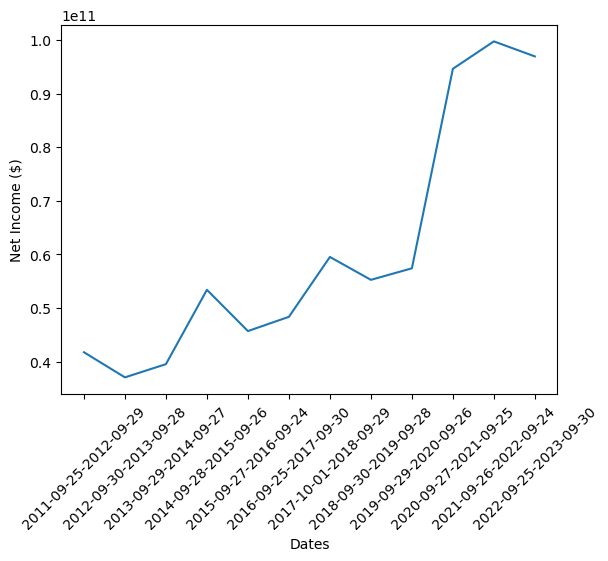

In [12]:
plt.figure()
plt.plot(extraction.income_statements.loc["NetIncomeLoss"])
plt.xticks(rotation=45)
plt.xlabel("Dates")
plt.ylabel("Net Income ($)")
plt.show()

## 2.2 Balance Sheets

In [13]:
extraction.merge_balance_sheets()

In [14]:
extraction.balance_sheets

,2011-09-24,2012-09-29,2013-09-28,2014-09-27,2015-09-26,2016-09-24,2017-09-30,2018-09-29,2019-09-28,2020-09-26,2021-09-25,2022-09-24,2023-09-30
CashAndCashEquivalentsAtCarryingValue,9.815000e+09,1.074600e+10,1.425900e+10,1.384400e+10,2.112000e+10,2.048400e+10,2.028900e+10,2.591300e+10,4.884400e+10,3.801600e+10,3.494000e+10,2.364600e+10,2.996500e+10
MarketableSecuritiesCurrent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.038800e+10,5.171300e+10,5.292700e+10,2.769900e+10,2.465800e+10,3.159000e+10
AccountsReceivableNetCurrent,NaN,NaN,1.310200e+10,1.746000e+10,1.684900e+10,1.575400e+10,1.787400e+10,2.318600e+10,2.292600e+10,1.612000e+10,2.627800e+10,2.818400e+10,2.950800e+10
NontradeReceivablesCurrent,NaN,NaN,7.539000e+09,9.759000e+09,1.349400e+10,1.354500e+10,1.779900e+10,2.580900e+10,2.287800e+10,2.132500e+10,2.522800e+10,3.274800e+10,3.147700e+10
InventoryNet,NaN,NaN,1.764000e+09,2.111000e+09,2.349000e+09,2.132000e+09,4.855000e+09,3.956000e+09,4.106000e+09,4.061000e+09,6.580000e+09,4.946000e+09,6.331000e+09
OtherAssetsCurrent,NaN,NaN,6.882000e+09,9.806000e+09,1.508500e+10,8.283000e+09,1.393600e+10,1.208700e+10,1.235200e+10,1.126400e+10,1.411100e+10,2.122300e+10,1.469500e+10
AssetsCurrent,NaN,NaN,7.328600e+10,6.853100e+10,8.937800e+10,1.068690e+11,1.286450e+11,1.313390e+11,1.628190e+11,1.437130e+11,1.348360e+11,1.354050e+11,1.435660e+11
MarketableSecuritiesNoncurrent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.707990e+11,1.053410e+11,1.008870e+11,1.278770e+11,1.208050e+11,1.005440e+11
PropertyPlantAndEquipmentNet,NaN,NaN,1.659700e+10,2.062400e+10,2.247100e+10,2.701000e+10,3.378300e+10,4.130400e+10,3.737800e+10,3.676600e+10,3.944000e+10,4.211700e+10,4.371500e+10
OtherAssetsNoncurrent,NaN,NaN,5.146000e+09,3.764000e+09,5.556000e+09,8.757000e+09,1.817700e+10,2.228300e+10,3.297800e+10,4.252200e+10,4.884900e+10,5.442800e+10,6.475800e+10


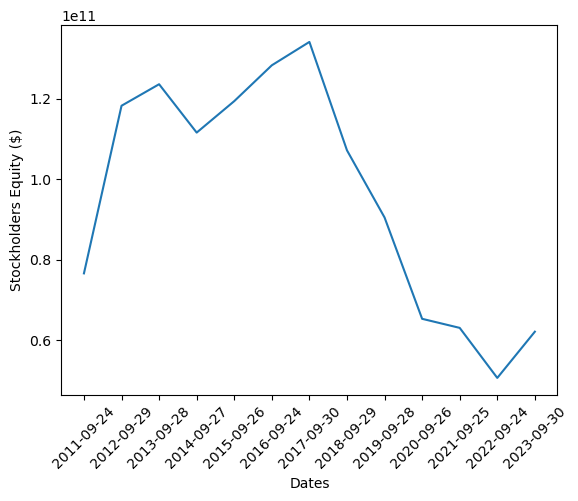

In [15]:
plt.figure()
plt.plot(extraction.balance_sheets.loc["StockholdersEquity"])
plt.xticks(rotation=45)
plt.xlabel("Dates")
plt.ylabel("Stockholders Equity ($)")
plt.show()

## 2.3 Cashlow Statements

In [16]:
extraction.merge_cashflow_statements()

In [17]:
extraction.cashflow_statements

,2011-09-24,2011-09-25-2012-09-29,2012-09-29,2012-09-30-2012-12-29,2012-09-30-2013-09-28,2012-12-30-2013-03-30,2013-03-31-2013-06-29,2013-06-30-2013-09-28,2013-09-28,2013-09-29-2013-12-28,...,2019-12-29-2020-03-28,2020-03-29-2020-06-27,2020-06-28-2020-09-26,2020-09-26,2020-09-27-2021-09-25,2021-09-25,2021-09-26-2022-09-24,2022-09-24,2022-09-25-2023-09-30,2023-09-30
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.978900e+10,NaN,3.592900e+10,NaN,2.497700e+10,NaN,3.073700e+10
NetIncomeLoss,NaN,4.173300e+10,NaN,1.307800e+10,3.703700e+10,9.547000e+09,6.900000e+09,7.512000e+09,NaN,1.307200e+10,...,1.124900e+10,1.125300e+10,1.267300e+10,NaN,9.468000e+10,NaN,9.980300e+10,NaN,9.699500e+10,NaN
DepreciationDepletionAndAmortization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.128400e+10,NaN,1.110400e+10,NaN,1.151900e+10,NaN
ShareBasedCompensation,NaN,1.740000e+09,NaN,NaN,2.253000e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.906000e+09,NaN,9.038000e+09,NaN,1.083300e+10,NaN
OtherNoncashIncomeExpense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.921000e+09,NaN,-1.110000e+08,NaN,2.227000e+09,NaN
IncreaseDecreaseInAccountsReceivable,NaN,5.551000e+09,NaN,NaN,2.172000e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.012500e+10,NaN,1.823000e+09,NaN,1.688000e+09,NaN
IncreaseDecreaseInOtherReceivables,NaN,1.414000e+09,NaN,NaN,-2.230000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.903000e+09,NaN,7.520000e+09,NaN,-1.271000e+09,NaN
IncreaseDecreaseInInventories,NaN,1.500000e+07,NaN,NaN,9.730000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.642000e+09,NaN,-1.484000e+09,NaN,1.618000e+09,NaN
IncreaseDecreaseInOtherOperatingAssets,NaN,3.162000e+09,NaN,NaN,-1.080000e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.042000e+09,NaN,6.499000e+09,NaN,5.684000e+09,NaN
IncreaseDecreaseInAccountsPayable,NaN,4.467000e+09,NaN,NaN,2.340000e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.232600e+10,NaN,9.448000e+09,NaN,-1.889000e+09,NaN


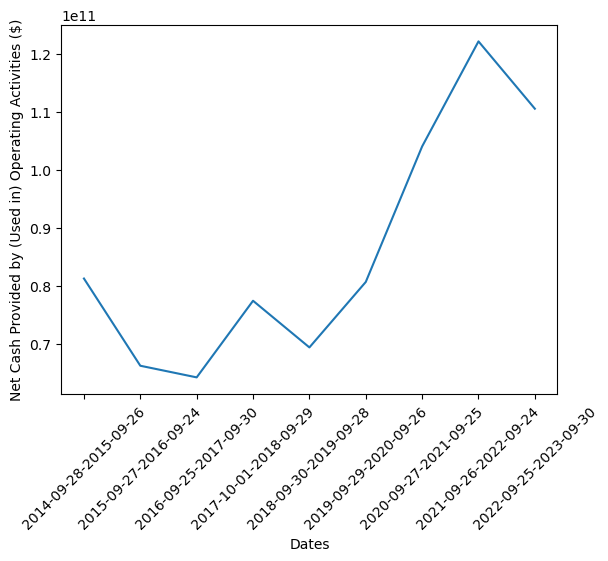

In [18]:
plt.figure()
plt.plot(
    extraction.cashflow_statements.loc[
        "NetCashProvidedByUsedInOperatingActivities"
    ].dropna()
)
plt.xticks(rotation=45)
plt.xlabel("Dates")
plt.ylabel("Net Cash Provided by (Used in) Operating Activities ($)")
plt.show()